# Net Zero Pledges

This notebooks prepares data for [the donut plot with carbon neutrality pledges](https://faktaoklimatu.cz/infografiky/emisni-zavazky) of different countries. We need to combine CO2 emission data together with information about carbon neutrality pledges.

## Load prerequisities

(The prerequisities had to be already installed, e.g. ``pip install -r notebooks/requirements.txt`` in terminal.)

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# load matplotlibrc file with nicer settings for plots
mpl.rc_file_defaults()

## CO2 emissions data

Emissions data are loaded from EDGAR database (Emissions Database for Global Atmospheric Research) published by Joint Research Centre of European Commission. We use the newest version [EDGAR v6.0](https://edgar.jrc.ec.europa.eu/dataset_ghg60) that contains emissions data for CO2, CH4 and N2O for all countries up to 2018. The values are given in Gg (gigagrams, i.e. thousands of tonnes).

As some countries pledged to climate neutrality (net-zero emissions of all greenhouse gases) and some countries pledged only to carbon neutrality (net-zero emissions of CO2 only), we will investigate only CO2 emissions to avoid inconsistencies. For detailed explanation, see our explainer [Co přesně znamená uhlíková neutralita?](https://faktaoklimatu.cz/explainery/uhlikova-neutralita) (in Czech only).

The EDGAR files were downloaded and unzipped into ``../data/edgar/v6.0/``.

In [3]:
# EDGAR v6.0
edgar_co2_path = '../data/edgar/v6.0/v60_CO2_excl_short-cycle_org_C_1970_2018.xls'

edgar_cols = {
    'Country_code_A3': 'code',
    'Y_2018': 'CO2'
}

edgar = pd.read_excel(edgar_co2_path, sheet_name='TOTALS BY COUNTRY', header=9)
edgar = edgar[list(edgar_cols)].rename(columns=edgar_cols)

# Do not exclude international shipping and aviation
# edgar = edgar[~edgar['code'].isin(['SEA', 'AIR'])]

In [4]:
edgar.head()

,code,CO2
0,CAN,5.922156e+05
1,SPM,5.199990e+01
2,USA,5.159174e+06
3,MEX,5.006034e+05
4,ABW,8.745909e+02


In [5]:
edgar['CO2'].sum()

37686953.862927556

Total world emissions of CO2 in 2018 were 37.7 billion tonnes (excluding LULUCF).

## Carbon neutrality pledges

We use the dataset compiled by [Net Zero Tracker](https://zerotracker.net). The latest snapshot at the time of writing this notebook is stored in ``../data/net-zero-tracker/``.

In [6]:
path = '../data/net-zero-tracker/snapshot_2022-03-30_05-05-02.xlsx'
net_zero = pd.read_excel(path)

In [7]:
net_zero.head()

,last_updated,id_code,name,country,actor_type,end_target,end_target_percentage_reduction,end_target_baseline_year,end_target_intensity_unit,end_target_baseline_emissions,...,memberships,gdp_real,annual_revenue,population,sector,employees,market_index,ghg,inventory_year,higher_net_zero
0,2022-03-15 13:20:26,COU-0001,Afghanistan,AFG,Country,Net zero,NaN,NaN,NaN,NaN,...,Climate Ambition Alliance,7.703769e+10,NaN,38928341.0,NaN,NaN,NaN,96590000.0,NaN,No
1,2022-03-25 13:17:22,COU-0002,Angola,AGO,Country,Emissions reduction target,21.0,2015.0,NaN,NaN,...,Climate Ambition Alliance,2.037080e+11,NaN,32866268.0,NaN,NaN,NaN,124590000.0,NaN,NaN
2,2022-03-15 13:20:35,COU-0003,Argentina,ARG,Country,Net zero,NaN,NaN,NaN,NaN,...,Climate Ambition Alliance,8.933110e+11,NaN,45376763.0,NaN,NaN,NaN,482080000.0,NaN,NaN
3,2022-03-15 13:37:34,COU-0004,Armenia,ARM,Country,Other,NaN,NaN,NaN,NaN,...,Climate Ambition Alliance,3.731493e+10,NaN,2963234.0,NaN,NaN,NaN,9400000.0,NaN,NaN
4,2022-03-14 16:30:38,COU-0005,Antigua and Barbuda,ATG,Country,Net zero,NaN,NaN,NaN,NaN,...,Climate Ambition Alliance,1.758426e+09,NaN,97928.0,NaN,NaN,NaN,1380000.0,NaN,NaN


The countries are keyed by alpha-3 ISO-3166 codes and the column ``end_target`` contains the type of pledge the country made. In addition the dataset contains many other rows such as net-zero pledges of companies.

In [8]:
# Filter on countries only (and remove European Union which is listed as a country with country code XXX).
net_zero = net_zero[(net_zero['actor_type'] == 'Country') & (net_zero['country'] != 'XXX')][['name', 'country', 'end_target']].copy()

# We consider a country to be committed to carbon neutrality if it set a target date for carbon neutrality, climate neutrality, net zero or zero carbon. European Union committed to net zero as the whole block, so we also consider all its members as committed to carbon neutrality.
pledges = ['Carbon neutral(ity)', 'Climate neutral', 'Net zero', 'Zero carbon']
eu = ['AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'MLT', 'NLD', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE']

net_zero['pledge'] = net_zero['end_target'].isin(pledges) | net_zero['country'].isin(eu)
net_zero = net_zero.rename(columns={'country': 'code'})

In [9]:
# There are 131 countries committed to carbon neutrality.
net_zero['pledge'].sum()

131

## Data merging

The set of countries in EDGAR dataset and NetZero dataset is not identical. Let's merge the datasets together,  investigate the differences and decide how to handle them.

In [10]:
df = pd.merge(edgar, net_zero, how='outer', indicator=True)
df['pledge'] = df['pledge'].fillna(False)

In [11]:
df[df['_merge'] == 'left_only'].sort_values('CO2', ascending=False)

,code,CO2,name,end_target,pledge,_merge
216,SEA,703568.764286,NaN,NaN,False,left_only
217,AIR,609402.253206,NaN,NaN,False,left_only
185,TWN,291396.642235,NaN,NaN,False,left_only
142,SCG,80380.327404,NaN,NaN,False,left_only
182,HKG,43595.709175,NaN,NaN,False,left_only
206,NCL,5230.940396,NaN,NaN,False,left_only
29,PRI,4006.934470,NaN,NaN,False,left_only
6,ANT,3261.431771,NaN,NaN,False,left_only
90,REU,2797.778173,NaN,NaN,False,left_only
183,MAC,2177.192155,NaN,NaN,False,left_only


EDGAR database contains many countries that we do not have net zero information about. `SEA` and `AIR` denotes international shipping and aviation respectively. The only countries with substantial emissions are Taiwan (TWN), Serbia and Montenegro (SCG, it does not exist as a single country anymore) and Hong Kong (HKG). We can safely ignore the rest. 

In [12]:
df[df['_merge'] == 'right_only']

,code,CO2,name,end_target,pledge,_merge
218,MCO,NaN,Monaco,Net zero,True,right_only
219,MHL,NaN,Marshall Islands,Net zero,True,right_only
220,AND,NaN,Andorra,Carbon neutral(ity),True,right_only
221,LIE,NaN,Liechtenstein,Emissions reduction target,False,right_only
222,MNE,NaN,Montenegro,Emissions reduction target,False,right_only
223,PSE,NaN,"Palestinian Territory, Occupied",Other,False,right_only
224,SMR,NaN,San Marino,Emissions reduction target,False,right_only
225,SRB,NaN,Serbia,Emissions reduction target,False,right_only
226,SSD,NaN,South Sudan,1.5°C target,False,right_only
227,NIU,NaN,Niue,Net zero,True,right_only


Net zero dataset contains Serbia and Montenegro correctly as two distinct countries, neither of them has a carbon neutrality pledge. Neither Taiwan or Hong Kong are included in the net zero dataset. However both these regions have already set their net-zero pledge, hence we will treat them as committed to carbon neutrality.
- [Carbon neutrality to 2050 for Hong Kong](https://www.climateready.gov.hk/files/pdf/CAP2050_leaflet_en.pdf)
- [Net zero to 2050 for Taiwan](https://www.taiwannews.com.tw/en/news/4279634)

In [13]:
df.loc[df['code'] == 'TWN', 'pledge'] = True
df.loc[df['code'] == 'HKG', 'pledge'] = True

## Aggregation and plotting

In our donut chart, we want to show only larger countries (with >1% of world CO2 emissions) with carbon neutrality pledges. We also want to show the European Union as a whole as it is the third largest emitter, just behind China and US.

In [14]:
df['CO2_pct'] = 100 * df['CO2'] / df['CO2'].sum()
df[df['CO2_pct'] > 1].sort_values('CO2', ascending=False)

,code,CO2,name,end_target,pledge,_merge,CO2_pct
181,CHN,1.128691e+07,China,Carbon neutral(ity),True,both,29.949117
2,USA,5.159174e+06,United States of America,Net zero,True,both,13.689550
174,IND,2.513568e+06,India,Net zero,True,both,6.669597
157,RUS,1.789768e+06,Russian Federation,Carbon neutral(ity),True,both,4.749038
198,JPN,1.174911e+06,Japan,Net zero,True,both,3.117553
110,DEU,7.572643e+05,Germany,Climate neutral,True,both,2.009354
216,SEA,7.035688e+05,NaN,NaN,False,left_only,1.866876
179,KOR,6.829088e+05,South Korea,Net zero,True,both,1.812056
160,IRN,6.644340e+05,"Iran, Islamic Republic of",Other,False,both,1.763034
217,AIR,6.094023e+05,NaN,NaN,False,left_only,1.617011


In [15]:
# Names of countries and categories are in Czech (we needed it for the chart -- the infographics on our website is directly based on the resulting plot). We will use these dictionaries to aggregate data up to larger sets that will be displayed in the chart.
large_pledged = {
    'Čína': ['CHN'],
    'USA': ['USA'],
    'EU-27': eu,
    'Indie': ['IND'], 
    'Rusko': ['RUS'],
    'Japonsko': ['JPN'],
    'Jižní Korea': ['KOR'],
    'Indonésie': ['IDN'],
    'Saudská Arábie': ['SAU'],
    'Kanada': ['CAN'],
    'Brazílie': ['BRA'],
    'Jihoafrická republika': ['ZAF'],
    'Turecko': ['TUR'],
    'Austrálie': ['AUS'],
    'Velká Británie': ['GBR']
}

large_pledged_flatten = [y for x in large_pledged.values() for y in x]
countries_with_pledge = list(df[df.pledge].code.values)
small_pledged = [x for x in countries_with_pledge if x not in large_pledged_flatten]
sea_air = ['SEA', 'AIR']
non_pledged = list(df[~df.pledge & ~df.code.isin(sea_air)].code.values)

to_display = {**large_pledged, 'Ostatní': small_pledged, 'Bez závazku': non_pledged, 'Mezinárodní námořní \na letecká doprava': sea_air}

In [16]:
# Data aggregation (the naming is in Czech)
pledged = pd.DataFrame([(k, df[df.code.isin(v)]['CO2'].sum() / 1e6) for k, v in to_display.items()], columns=['region', 'co2_emissions'])
co2_all = pledged['co2_emissions'].sum()
pledged['share'] = pledged['co2_emissions'] / co2_all
pledged['label'] = pledged.apply(lambda x: '{} {:.3g} %'.format(x['region'], x['share'] * 100).replace('.', ','), axis=1)

pledged

,region,co2_emissions,share,label
0,Čína,11.286910,0.299491,"Čína 29,9 %"
1,USA,5.159174,0.136895,"USA 13,7 %"
2,EU-27,3.070547,0.081475,"EU-27 8,15 %"
3,Indie,2.513568,0.066696,"Indie 6,67 %"
4,Rusko,1.789768,0.047490,"Rusko 4,75 %"
5,Japonsko,1.174911,0.031176,"Japonsko 3,12 %"
6,Jižní Korea,0.682909,0.018121,"Jižní Korea 1,81 %"
7,Indonésie,0.607484,0.016119,"Indonésie 1,61 %"
8,Saudská Arábie,0.593356,0.015744,"Saudská Arábie 1,57 %"
9,Kanada,0.592216,0.015714,"Kanada 1,57 %"


In [17]:
countries_with_pledges = df['pledge'].sum() - 2  # We do not count Taiwan and Hong Kong as sovereign countries here.
CO2_pct_covered_by_pledges = df[df['pledge']]['CO2_pct'].sum()

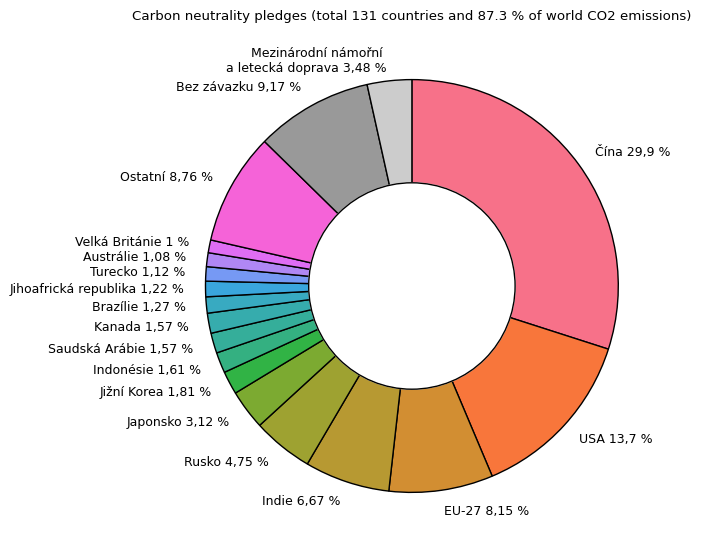

In [18]:
# Matplotlib does not support donut chart by default, hence we need to create a pie chart and then overlay it with the inner white circle.

# Seaborn can provide us with a nicely spaced color palette (and we add two different grey colors for the countries without pledge and for international shipping and aviation).
colors = [x for x in sns.color_palette('husl', 17)][:16] + [(0.6, 0.6, 0.6), (0.8, 0.8, 0.8)]

_, ax = plt.subplots()
plt.pie(pledged['co2_emissions'], colors=colors, labels=pledged['label'], counterclock=False, startangle=90, wedgeprops={'linewidth': 1, 'edgecolor': 'black'})

# Overlay the pie chart with white circle with black edge.
inner_circle_fill = plt.Circle((0, 0), 0.5, color='white')
inner_circle_edge = plt.Circle((0, 0), 0.5, color='black', fill=False)
ax.add_artist(inner_circle_fill)
ax.add_artist(inner_circle_edge)

ax.set_title(f'Carbon neutrality pledges (total {countries_with_pledges} countries and {CO2_pct_covered_by_pledges:.1f} % of world CO2 emissions)')
None